In [1]:
import sys
sys.path.append('..//')

import jax
import numpy as np
import jax.numpy as jnp
from functools import partial
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)

from parsmooth._base import MVNStandard, FunctionalModel, MVNSqrt
from parsmooth.linearization import cubature, extended, gauss_hermite
from parsmooth.methods import iterated_smoothing
from bearing_data import get_data, make_parameters


In [3]:
s1 = jnp.array([-1.5, 0.5])  # First sensor location
s2 = jnp.array([1., 1.])  # Second sensor location
r = 0.5  # Observation noise (stddev)
x0 = jnp.array([0.1, 0.2, 1, 0])  # initial true location
dt = 0.01  # discretization time step
qc = 0.01  # discretization noise
qw = 0.1  # discretization noise

Q, R, observation_function, transition_function = make_parameters(qc, qw, r, dt, s1, s2)

chol_Q = jnp.linalg.cholesky(Q)
chol_R = jnp.linalg.cholesky(R)

m0 = jnp.array([-4., -1., 2., 7., 3.])
chol_P0 = jnp.eye(5)
P0 = jnp.eye(5)

init = MVNStandard(m0, P0)
chol_init = MVNSqrt(m0, chol_P0)


sqrt_transition_model = FunctionalModel(transition_function, MVNSqrt(jnp.zeros((5,)), chol_Q))
transition_model = FunctionalModel(transition_function, MVNStandard(jnp.zeros((5,)), Q))

sqrt_observation_model = FunctionalModel(observation_function, MVNSqrt(jnp.zeros((2,)), chol_R))
observation_model = FunctionalModel(observation_function, MVNStandard(jnp.zeros((2,)), R))

# Cubature

In [ ]:
# Parallel

iteration = 20
Ts = [100, 500, 1000, 2000, 5000, 7000, 10000]
for i, T in enumerate(Ts):
    _, true_states, ys = get_data(x0, dt, r, T, s1, s2)
    initial_states =  MVNStandard(jnp.repeat(jnp.array([[-1., -1., 6., 4., 2.]]),T + 1, axis=0),
                                                         jnp.repeat(jnp.eye(5).reshape(1, 5, 5), T + 1, axis=0))
    initial_states_sqrt = MVNSqrt(jnp.repeat(jnp.array([[-1., -1., 6., 4., 2.]]),T + 1, axis=0),
                                  jnp.repeat(jnp.eye(5).reshape(1, 5, 5), T + 1, axis=0))

    _, ell_cubature_par[i] = iterated_smoothing(ys, init, transition_model, observation_model,
                                         cubature, initial_states, True,
                                         criterion=lambda i, *_: i < iteration,
                                         return_loglikelihood = True)

    _, ell_cubature_sqrt_par[i] = iterated_smoothing(ys, chol_init, sqrt_transition_model, sqrt_observation_model,
                                              cubature, initial_states_sqrt, True,
                                              criterion=lambda i, *_: i < iteration,
                                              return_loglikelihood = True)
    if math.isnan(ell_cubature_sqrt_par):
        break
    
    

In [18]:
jnp.savez("ell_float64",
          ell_cubature_par=jnp.array(ell_cubature_par),
          ell_cubature_sqrt_par=jnp.array(ell_cubature_sqrt_par))

False

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(Ts, ell_cubature_par,'g', label = "sqrt_seq")
plt.plot(Ts, ell_cubature_sqrt_par,'k', label = "sqrt_par")
plt.legend();



In [12]:
# iteration = 20
# T = 50000
# _, true_states, ys = get_data(x0, dt, r, T, s1, s2)
# initial_states =  MVNStandard(jnp.repeat(jnp.array([[-1., -1., 6., 4., 2.]]),T + 1, axis=0),
#                                                      jnp.repeat(jnp.eye(5).reshape(1, 5, 5), T + 1, axis=0))
# initial_states_sqrt = MVNSqrt(jnp.repeat(jnp.array([[-1., -1., 6., 4., 2.]]),T + 1, axis=0),
#                               jnp.repeat(jnp.eye(5).reshape(1, 5, 5), T + 1, axis=0))
# _, ell_cubature_seq = iterated_smoothing(ys, init, transition_model, observation_model,
#                                      cubature, initial_states, False,
#                                      criterion=lambda i, *_: i < iteration,
#                                       return_loglikelihood = True)

# # square-root
# _, ell_cubature_sqrt_seq = iterated_smoothing(ys, chol_init, sqrt_transition_model, sqrt_observation_model,
#                                           cubature, initial_states_sqrt, False,
#                                           criterion=lambda i, *_: i < iteration,
#                                           return_loglikelihood = True)

In [10]:
np.testing.assert_array_almost_equal(iterated_res_seq.mean, iterated_res_par.mean, decimal=7)

np.testing.assert_array_almost_equal(iterated_res_seq.cov, iterated_res_par.cov, decimal=7)

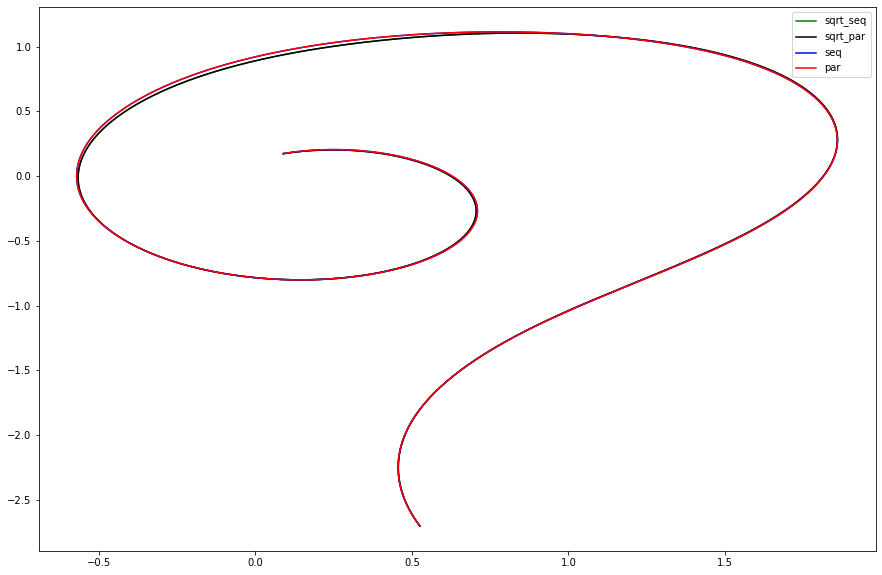

In [13]:
plt.figure(figsize=(15, 10))
plt.plot(sqrt_iterated_res_seq.mean[:,0], sqrt_iterated_res_seq.mean[:,1],'g', label = "sqrt_seq")
plt.plot(sqrt_iterated_res_par.mean[:,0], sqrt_iterated_res_par.mean[:,1],'k', label = "sqrt_par")
plt.plot(iterated_res_seq.mean[:,0], iterated_res_seq.mean[:,1],'b', label = "seq")
plt.plot(iterated_res_par.mean[:,0], iterated_res_par.mean[:,1],'r', label = "par")
plt.legend();



In [ ]:
Extended